In [1]:
#pip install transformers[torch]
#pip install accelerate -U
#pip install huggingface-hub
#pip install transformers
#pip install datasets

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [2]:
data_path = "../data/articles_with_topics_assigned.csv"

In [3]:
data = pd.read_csv(data_path)

In [4]:
print(data.head())

data = data.drop(columns=['ID'])

data.rename(columns={'Topic': 'labels'}, inplace=True)
data.rename(columns={'Content': 'text'}, inplace=True)
print(data.head())

   ID                                            Content  \
0   0  congressional republican new fear come health ...   
1   1  bullet shell get counted blood dry votive cand...   
2   2  walt disney bambi opened critic praised spare ...   
3   3  death may great equalizer isnt necessarily eve...   
4   4  north korea leader kim said sunday country mak...   

                                Topic  
0          Legal and Judicial Systems  
1               Court cases and Crime  
2            Entertainment and Sports  
3            Entertainment and Sports  
4  International Affairs and Military  
                                                text  \
0  congressional republican new fear come health ...   
1  bullet shell get counted blood dry votive cand...   
2  walt disney bambi opened critic praised spare ...   
3  death may great equalizer isnt necessarily eve...   
4  north korea leader kim said sunday country mak...   

                               labels  
0          Legal and J

In [5]:
unique_topics = data['labels'].unique()
topic_index = {}

for index,topic in enumerate(unique_topics):
    topic_index[topic] = index

In [6]:
topic_index

{'Legal and Judicial Systems': 0,
 'Court cases and Crime': 1,
 'Entertainment and Sports': 2,
 'International Affairs and Military': 3,
 'Health, Science, Environment, and Technology': 4,
 'American Politics and Society': 5,
 'Business and Economy': 6,
 'Political Campaigns and Election': 7,
 'Politics and Media': 8}

In [7]:
def topic_to_index(topic):
    index = topic_index[topic]
    return index

data['labels'] = data['labels'].apply(lambda x: topic_to_index(x))

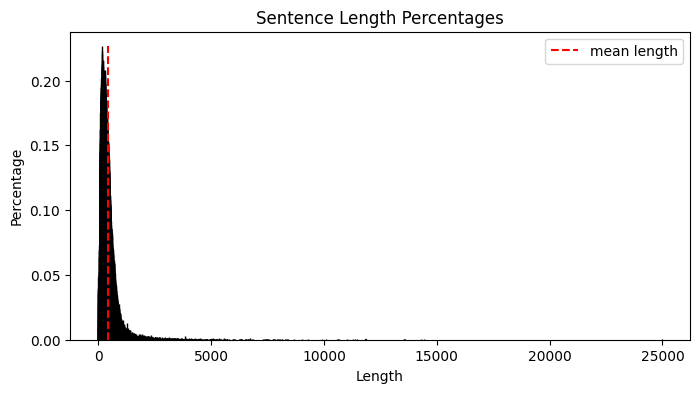

In [8]:
content_lst = data['text'].tolist()
content_len_lst = [len(content.split()) for content in content_lst]
num_articles = len(content_lst)

counter = Counter(content_len_lst)
x = sorted(counter)
y = [counter[i]/num_articles*100 for i in x]
avg_len = sum(content_len_lst) / num_articles

plt.figure(num=None, figsize=(8, 4))

plt.bar(x, y, edgecolor='black')
plt.plot([avg_len, avg_len], [0, max(y)], lw=1.5, linestyle="--", color='red')
plt.legend(['mean length'])
plt.title('Sentence Length Percentages')
plt.ylabel("Percentage")
plt.xlabel("Length")
plt.show()

In [9]:
print(f'The average sentence length is {avg_len}')

The average sentence length is 412.3291305895708


In [10]:
from sklearn.model_selection import train_test_split

train, remaining = train_test_split(data, test_size=0.3, random_state=42)
validation, test = train_test_split(remaining, test_size=0.5, random_state=42)

In [11]:
print(f"Training Set: {len(train)} samples")
print(f"Validation Set: {len(validation)} samples")
print(f"Testing Set: {len(test)} samples")

Training Set: 104209 samples
Validation Set: 22331 samples
Testing Set: 22331 samples


In [12]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train)
validation_dataset = Dataset.from_pandas(validation)
test_dataset = Dataset.from_pandas(test)

train_dataset = train_dataset.remove_columns(['__index_level_0__'])
validation_dataset = validation_dataset.remove_columns(['__index_level_0__'])
test_dataset = test_dataset.remove_columns(['__index_level_0__'])

data = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [13]:
from transformers import DistilBertTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [14]:
model_max_size = tokenizer.model_max_length
print(f"Model's maximum context size is {model_max_size}")

Model's maximum context size is 512


In [15]:
# Model's maximum context size is 512.
# Pad or truncate to meet the size limit.
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

data_encoded = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/104209 [00:00<?, ? examples/s]

Map:   0%|          | 0/22331 [00:00<?, ? examples/s]

Map:   0%|          | 0/22331 [00:00<?, ? examples/s]

In [16]:
data_encoded.save_to_disk('tokenized_dataset')

Saving the dataset (0/2 shards):   0%|          | 0/104209 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22331 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22331 [00:00<?, ? examples/s]

In [17]:
from datasets import load_from_disk

data_encoded = load_from_disk('tokenized_dataset')

In [18]:
print(data_encoded["train"].column_names)

['text', 'labels', 'input_ids', 'attention_mask']


In [19]:
data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [20]:
from transformers import AutoModelForSequenceClassification

num_labels = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Defining the performance metrics

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [19]:
# Wanted to try out pushing the model to my Hugging Face Hub.

from huggingface_hub import notebook_login

notebook_login()

In [40]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(data_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-article-classification"
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy="epoch",
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=True,
                                 log_level="error")


In [41]:
trainer = Trainer(model=model, args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=data_encoded["train"],
                 eval_dataset=data_encoded["validation"],
                 tokenizer=tokenizer)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.238300,0.254289,0.907572,0.907777
2,0.147200,0.287802,0.914155,0.914318


TrainOutput(global_step=13028, training_loss=0.19276422119905584, metrics={'train_runtime': 6890.5345, 'train_samples_per_second': 30.247, 'train_steps_per_second': 1.891, 'total_flos': 2.7612036813182976e+16, 'train_loss': 0.19276422119905584, 'epoch': 2.0})

In [42]:
preds_output = trainer.predict(data_encoded["validation"])

In [43]:
preds_output.metrics

{'test_loss': 0.28780195116996765,
 'test_accuracy': 0.9141552102458466,
 'test_f1': 0.9143176888062088,
 'test_runtime': 236.3626,
 'test_samples_per_second': 94.478,
 'test_steps_per_second': 5.906}

In [44]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(data_encoded["validation"]["labels"])
labels = list(topic_index.keys())

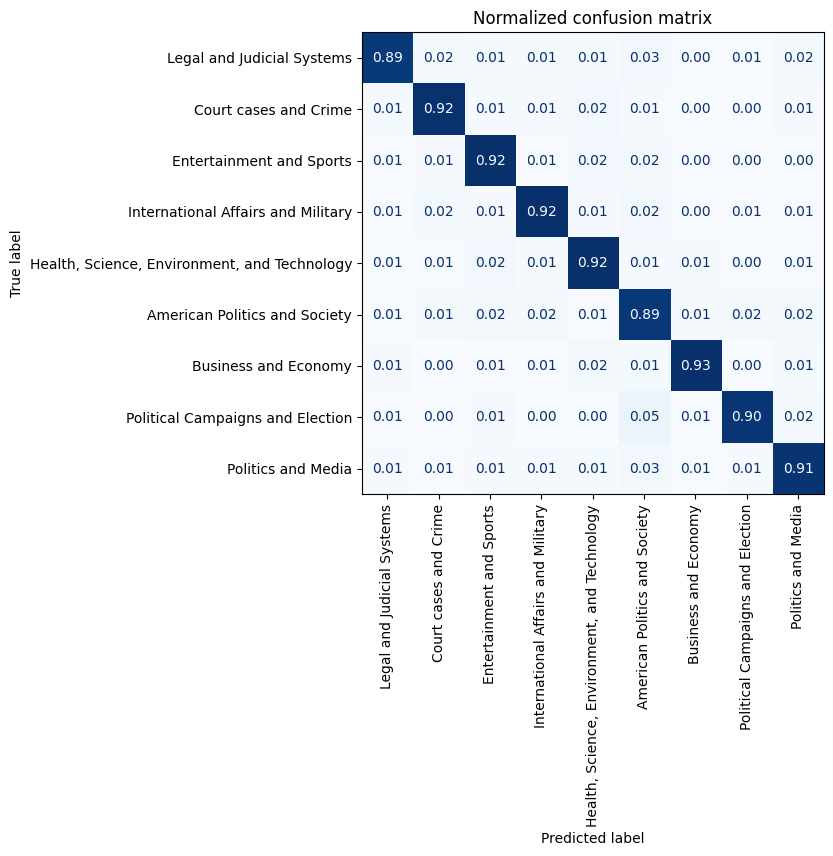

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

In [160]:
trainer.push_to_hub(commit_message="Training Completed")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/Junb0ng/distilbert-base-uncased-finetuned-article-classification/tree/main/'

In [161]:
from transformers import pipeline

In [163]:
my_model = "Junb0ng/distilbert-base-uncased-finetuned-article-classification"
classifier = pipeline("text-classification", model=my_model)

config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

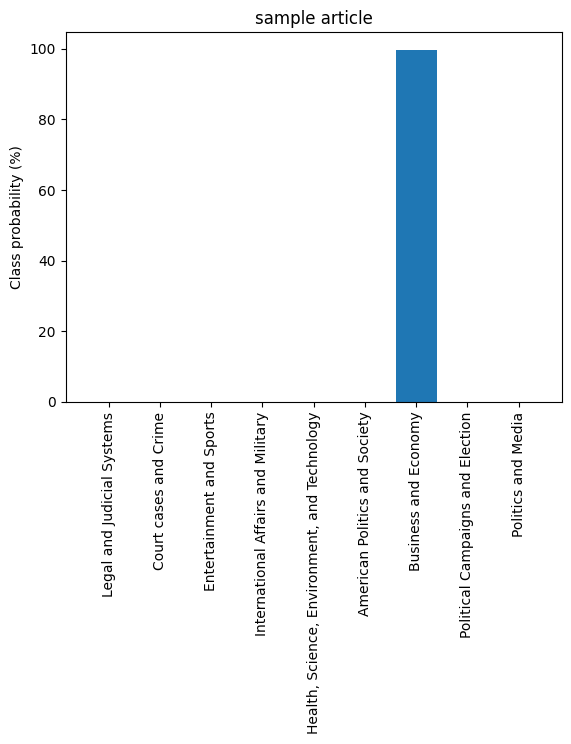

In [167]:
sample_article = """
“Bitcoin breaking $40,000 isn’t as juicy as the first time it happened in January 2021,” said Antoni Trenchev, co-founder of the crypto lender Nexo. “Yet consider where we were a year ago, at $15,500, and this is a significant upturn in fortunes for an asset that looked dead and buried.”

The rally also reflects investors’ eagerness to move on from crypto’s most recent scandals. Last month, Changpeng Zhao, the billionaire founder of the world’s largest cryptocurrency exchange, Binance, pleaded guilty to federal money-laundering charges and resigned from his role as CEO. That came just weeks after a jury convicted FTX co-founder Sam Bankman-Fried of orchestrating a multibillion-dollar fraud.

Bitcoin is now up 150% for the year, though it remains far from its historical high of $69,000 in November of 2021.
"""

preds = classifier(sample_article, return_all_scores=True)

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'sample article')
plt.ylabel("Class probability (%)")
plt.xticks(rotation=90)
plt.show()
